In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
msambare_fer2013_path = kagglehub.dataset_download('msambare/fer2013')

print('Data source import complete.')


Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Streaming output truncated to the last 5000 lines.
/kaggle/input/fer2013/train/happy/Training_71717074.jpg
/kaggle/input/fer2013/train/happy/Training_83349364.jpg
/kaggle/input/fer2013/train/happy/Training_8224205.jpg
/kaggle/input/fer2013/train/happy/Training_69103613.jpg
/kaggle/input/fer2013/train/happy/Training_7098848.jpg
/kaggle/input/fer2013/train/happy/Training_38129729.jpg
/kaggle/input/fer2013/train/happy/Training_95151390.jpg
/kaggle/input/fer2013/train/happy/Training_66874071.jpg
/kaggle/input/fer2013/train/happy/Training_23294249.jpg
/kaggle/input/fer2013/train/happy/Training_86508875.jpg
/kaggle/input/fer2013/train/happy/Training_50691325.jpg
/kaggle/input/fer2013/train/happy/Training_26593901.jpg
/kaggle/input/fer2013/train/happy/Training_81451115.jpg
/kaggle/input/fer2013/train/happy/Training_39982194.jpg
/kaggle/input/fer2013/train/happy/Training_18980574.jpg
/kaggle/input/fer2013/train/happy/Training_39446205.jpg
/kaggle/input/fer2013/train/happy/Training_9457008.jpg


# PREPROCESSING AND MODEL BUILDING

## Importing Required Libraries

In this step, we import essential libraries for data manipulation, visualization, and deep learning. These include:
- `numpy` for numerical operations
- `matplotlib` and `seaborn` for visualizing data and model performance
- `tensorflow` and `ImageDataGenerator` from Keras for building and training the deep learning model


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


## Preparing Image Data Generators

In this step, we set up data generators to efficiently load and preprocess the FER-2013 dataset.

- The training and validation sets are loaded from the `train` directory using `ImageDataGenerator` with a 10% validation split and grayscale conversion.
- Images are rescaled to the `[0, 1]` range and resized to 48×48 pixels.
- The `test_generator` loads the test data from the `test` directory with similar preprocessing but without shuffling or splitting.

This setup enables real-time data loading during model training and evaluation.


In [4]:
img_size = (48, 48)
batch_size = 64
train_dir = '/kaggle/input/fer2013/train'
test_dir = '/kaggle/input/fer2013/test'

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 25841 images belonging to 7 classes.
Found 2868 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


## Visualizing Sample Training Images

To better understand the dataset, we display a few sample images from the training generator along with their corresponding emotion labels.

- The `show_samples` function fetches one batch of images and labels.
- It visualizes 10 grayscale images in a 2×5 grid.
- Each image is labeled with its corresponding emotion class using `class_names`.

This helps verify that the data is being loaded and labeled correctly.


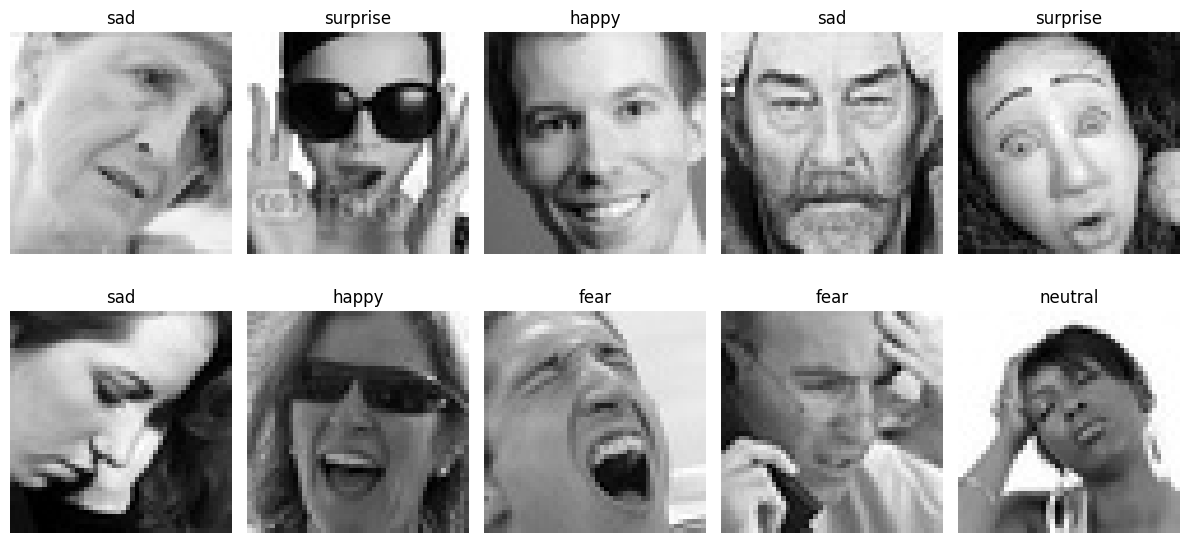

In [5]:
class_names = list(train_generator.class_indices.keys())

def show_samples(generator):
    images, labels = next(generator)
    plt.figure(figsize=(12, 6))
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].reshape(48, 48), cmap="gray")
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_samples(train_generator)


## Data Augmentation

To improve model generalization and reduce overfitting, we apply data augmentation to the training images using `ImageDataGenerator`.

- Images are rescaled to the `[0, 1]` range.
- Random transformations include:
  - Rotation (up to 20 degrees)
  - Zoom (up to 20%)
  - Horizontal flipping
- A 20% validation split is defined for separating training and validation data.
- A separate `ImageDataGenerator` is created for the test set, applying only rescaling.

This setup ensures the model sees diverse variations of the training images during training.


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (48, 48)
batch_size = 64

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)


In [7]:
train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/fer2013/train',
    target_size=img_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    '/kaggle/input/fer2013/train',
    target_size=img_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/fer2013/test',
    target_size=img_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


## Training Callbacks

To optimize training and prevent overfitting, we define two important callbacks:

- `ReduceLROnPlateau`: Monitors the validation loss and reduces the learning rate by a factor of 0.2 if it doesn't improve for 4 consecutive epochs.
- `EarlyStopping`: Stops training early if the validation loss does not improve for 8 consecutive epochs and restores the best model weights.

These callbacks help the model converge more efficiently and avoid unnecessary training once performance plateaus.


In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=4,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    verbose=1
)


## Training Model

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization

input_shape = (48, 48, 1)

model = Sequential()

# Block 1
model.add(Conv2D(64, (3,3), activation='relu', input_shape=input_shape, padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Block 2
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Block 3
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Fully Connected
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [12]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,359,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,510,215 (13.39 MB)

 Trainable params: 3,507,911 (13.38 MB)

 Non-trainable params: 2,304 (9.00 KB)

In [13]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
# from tensorflow.keras.layers import Flatten, Dense, Dropout

# input_shape = (48, 48, 1)  # FER-2013 images are grayscale

# model = Sequential([
#     Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
#     BatchNormalization(),
#     MaxPooling2D(2, 2),

#     Conv2D(128, (3, 3), activation='relu', padding='same'),
#     BatchNormalization(),
#     MaxPooling2D(2, 2),

#     Conv2D(256, (3, 3), activation='relu', padding='same'),
#     BatchNormalization(),
#     MaxPooling2D(2, 2),

#     Flatten(),

#     Dense(128, activation='relu'),
#     Dropout(0.5),

#     Dense(7, activation='softmax')  # 7 emotion classes
# ])
# model.compile(
#     optimizer='adam',
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )
# model.summary()

In [14]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stop, reduce_lr]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 174s 441ms/step - accuracy: 0.2214 - loss: 2.3424 - val_accuracy: 0.1218 - val_loss: 4.3386 - learning_rate: 0.0010
Epoch 2/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 42s 117ms/step - accuracy: 0.3430 - loss: 1.7470 - val_accuracy: 0.3865 - val_loss: 1.6155 - learning_rate: 0.0010
Epoch 3/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 84s 122ms/step - accuracy: 0.4257 - loss: 1.5060 - val_accuracy: 0.4560 - val_loss: 1.4186 - learning_rate: 0.0010
Epoch 4/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 40s 112ms/step - accuracy: 0.4828 - loss: 1.3526 - val_accuracy: 0.4541 - val_loss: 1.4479 - learning_rate: 0.0010
Epoch 5/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 39s 110ms/step - accuracy: 0.5172 - loss: 1.2730 - val_accuracy: 0.4626 - val_loss: 1.4059 - learning_rate: 0.0010
Epoch 6/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 40s 111ms/step - accuracy: 0.5279 - loss: 1.2395 - val_accuracy: 0.5198 - val_loss: 1.2625 - learning_rate: 0.0010
Epoch 7/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 40s 112ms/step - accuracy: 0.

## Visualizing Training and Validation Performance



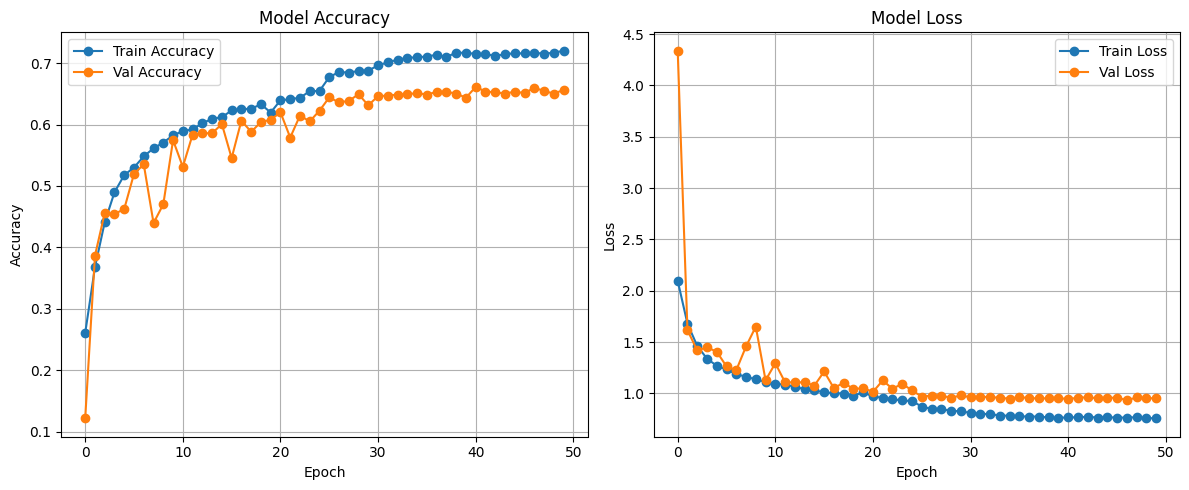

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


- The model shows a gradual improvement in both training and validation accuracy.
- Validation accuracy slightly lags behind training accuracy.
- Training and validation loss consistently decline over the epochs.
- The decrease in loss indicates effective learning and minimization of error.

## Evaluating the Model on Test Data


In [16]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")


113/113 ━━━━━━━━━━━━━━━━━━━━ 34s 306ms/step - accuracy: 0.6284 - loss: 1.0464
Test Accuracy: 0.6704
Test Loss: 0.9450


- The images are low resolution (48×48 grayscale)

- There's class imbalance and ambiguous expressions

- FER-2013 is noisy and was never meant to reach near-perfect performance



# PREDICTIONS

In [17]:
import numpy as np

pred_probs = model.predict(test_generator)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())


113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step


## 50 RANDOM PREDICTIONS

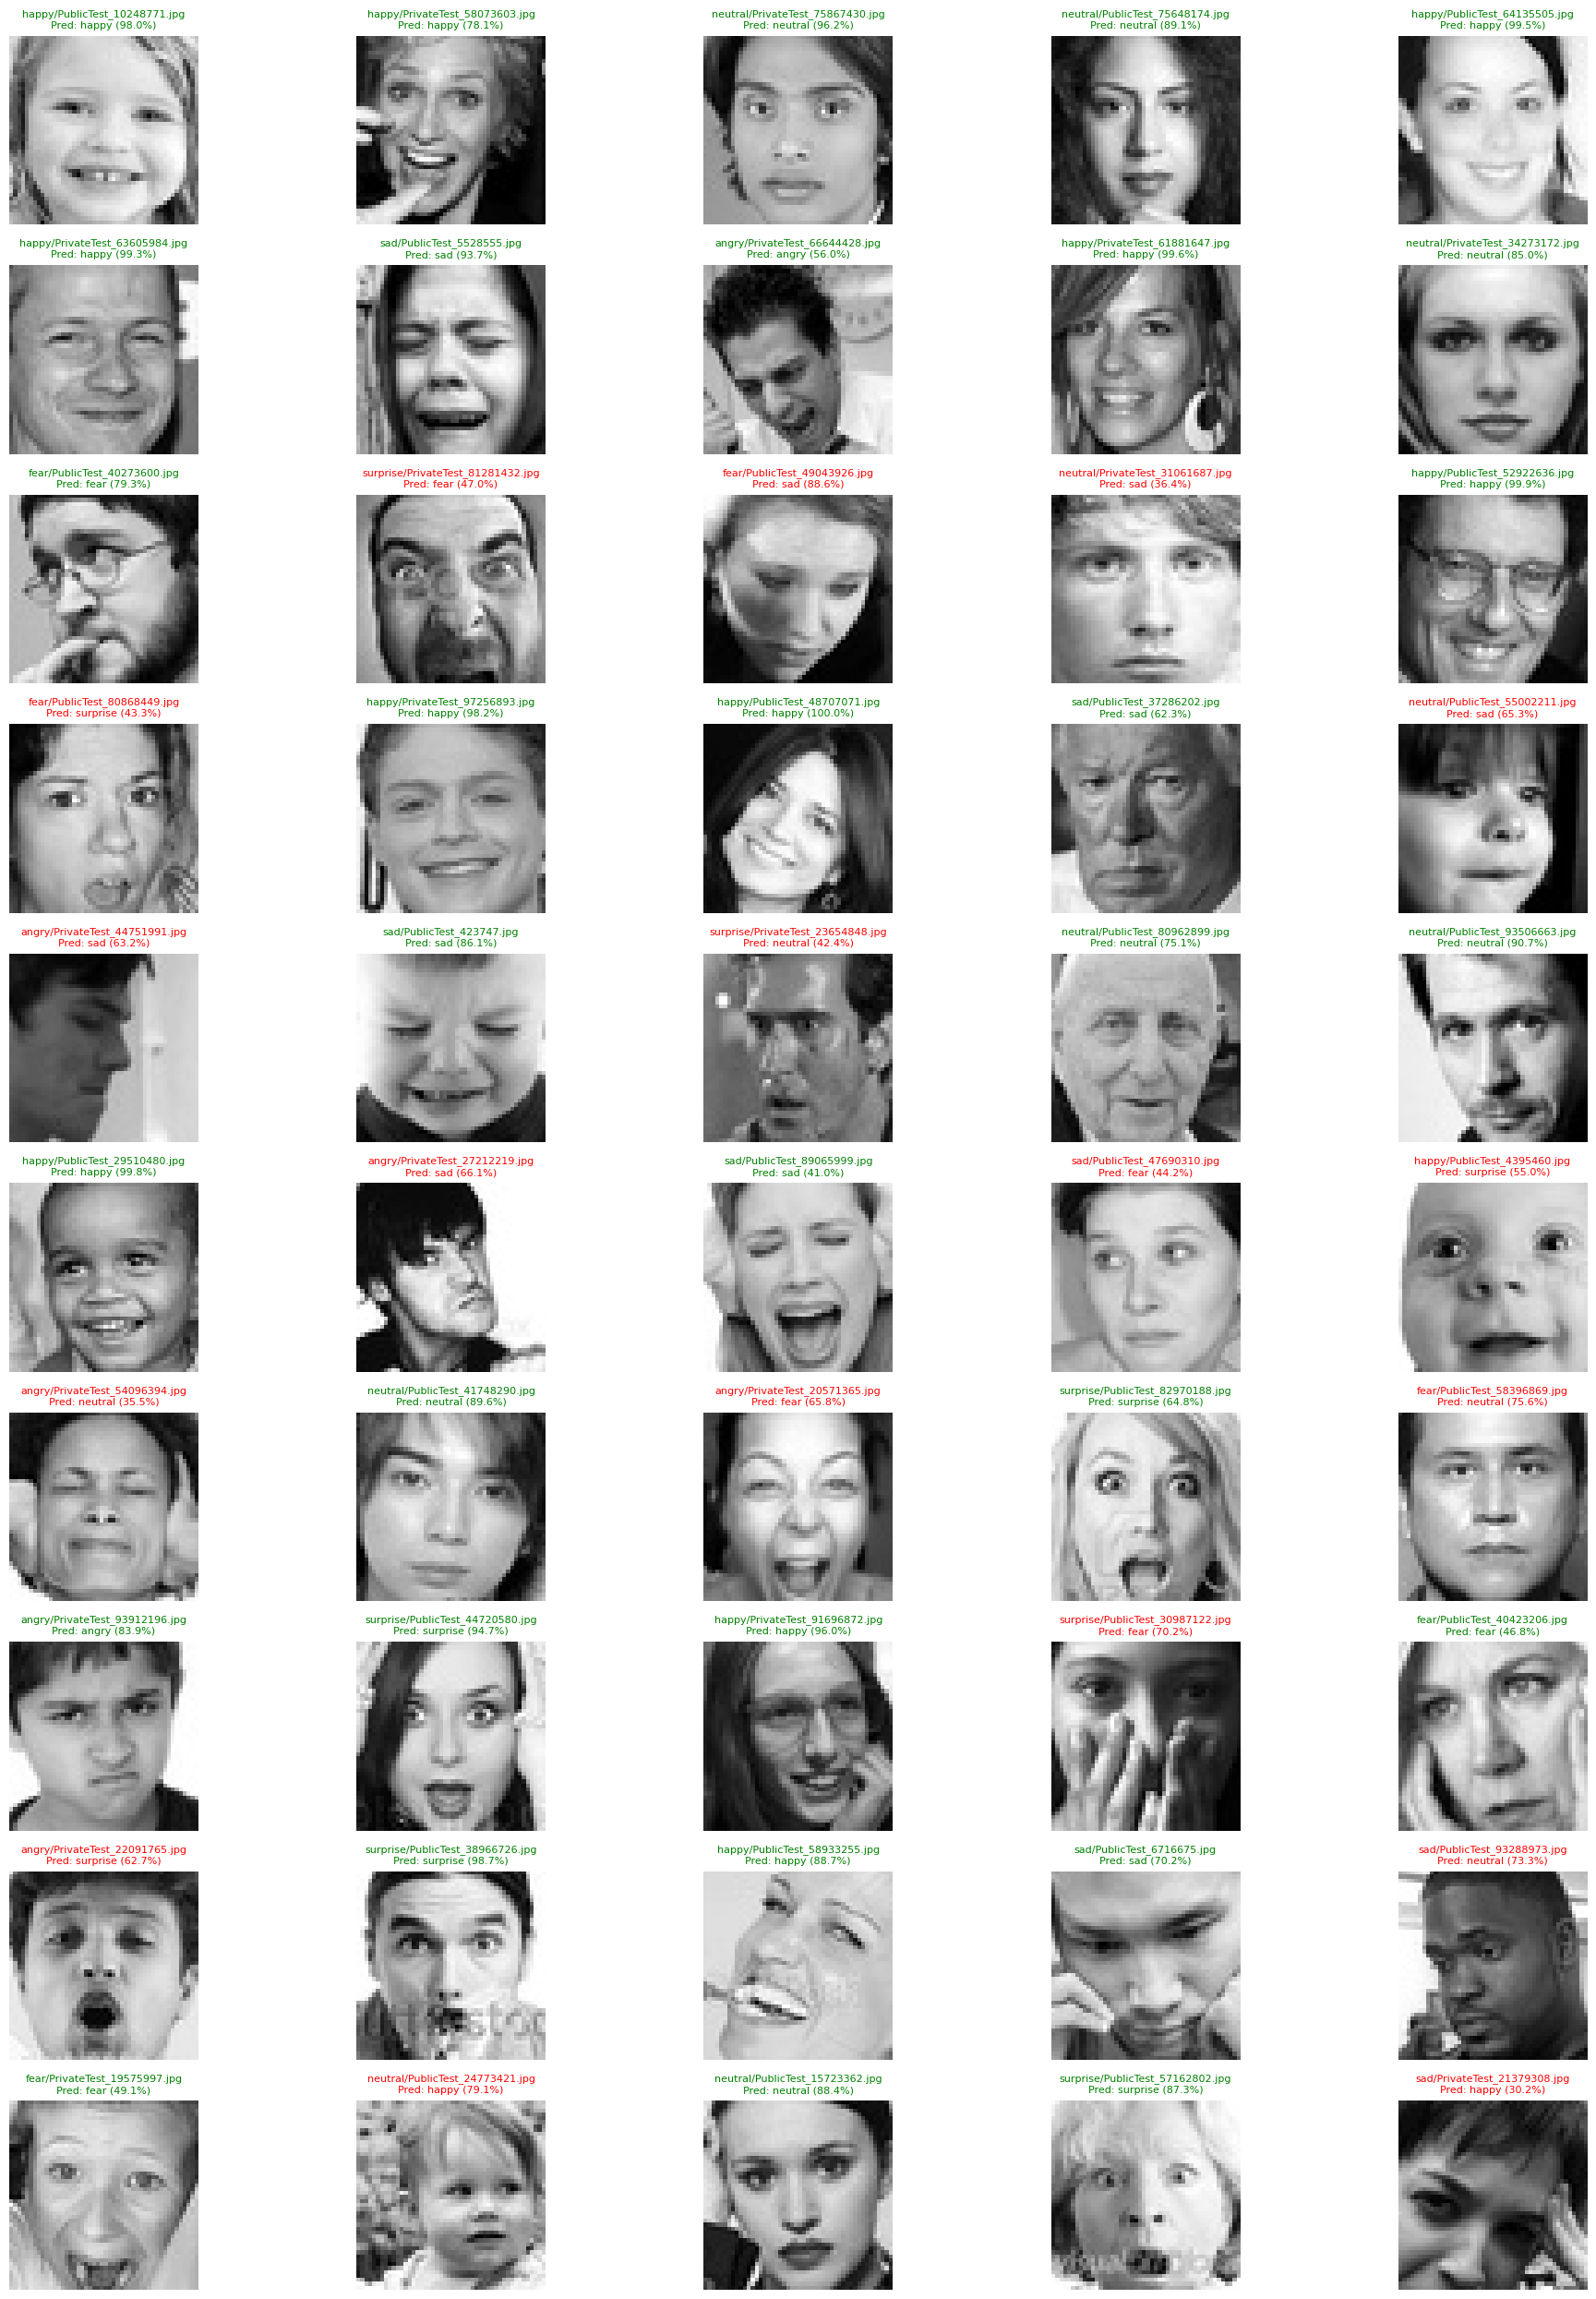

 Correctly Predicted: 32 / 50


In [18]:
import matplotlib.pyplot as plt
import numpy as np
import os

filenames = test_generator.filepaths

plt.figure(figsize=(20, 25))
correct_count = 0
for i in range(50):
    index = np.random.randint(0, len(filenames))
    img_path = filenames[index]
    img = plt.imread(img_path)

    class_name = os.path.basename(os.path.dirname(img_path))
    filename = os.path.basename(img_path)

    true_label = class_labels[true_classes[index]]
    pred_label = class_labels[pred_classes[index]]
    confidence = np.max(pred_probs[index]) * 100

    if pred_label == true_label:
        correct_count += 1

    plt.subplot(10, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    title_color = 'green' if pred_label == true_label else 'red'
    plt.title(f'{class_name}/{filename}\nPred: {pred_label} ({confidence:.1f}%)',
              fontsize=8, color=title_color)

plt.tight_layout()
plt.show()

print(f' Correctly Predicted: {correct_count} / 50')


## 100 RANDOM PREDICTIONS

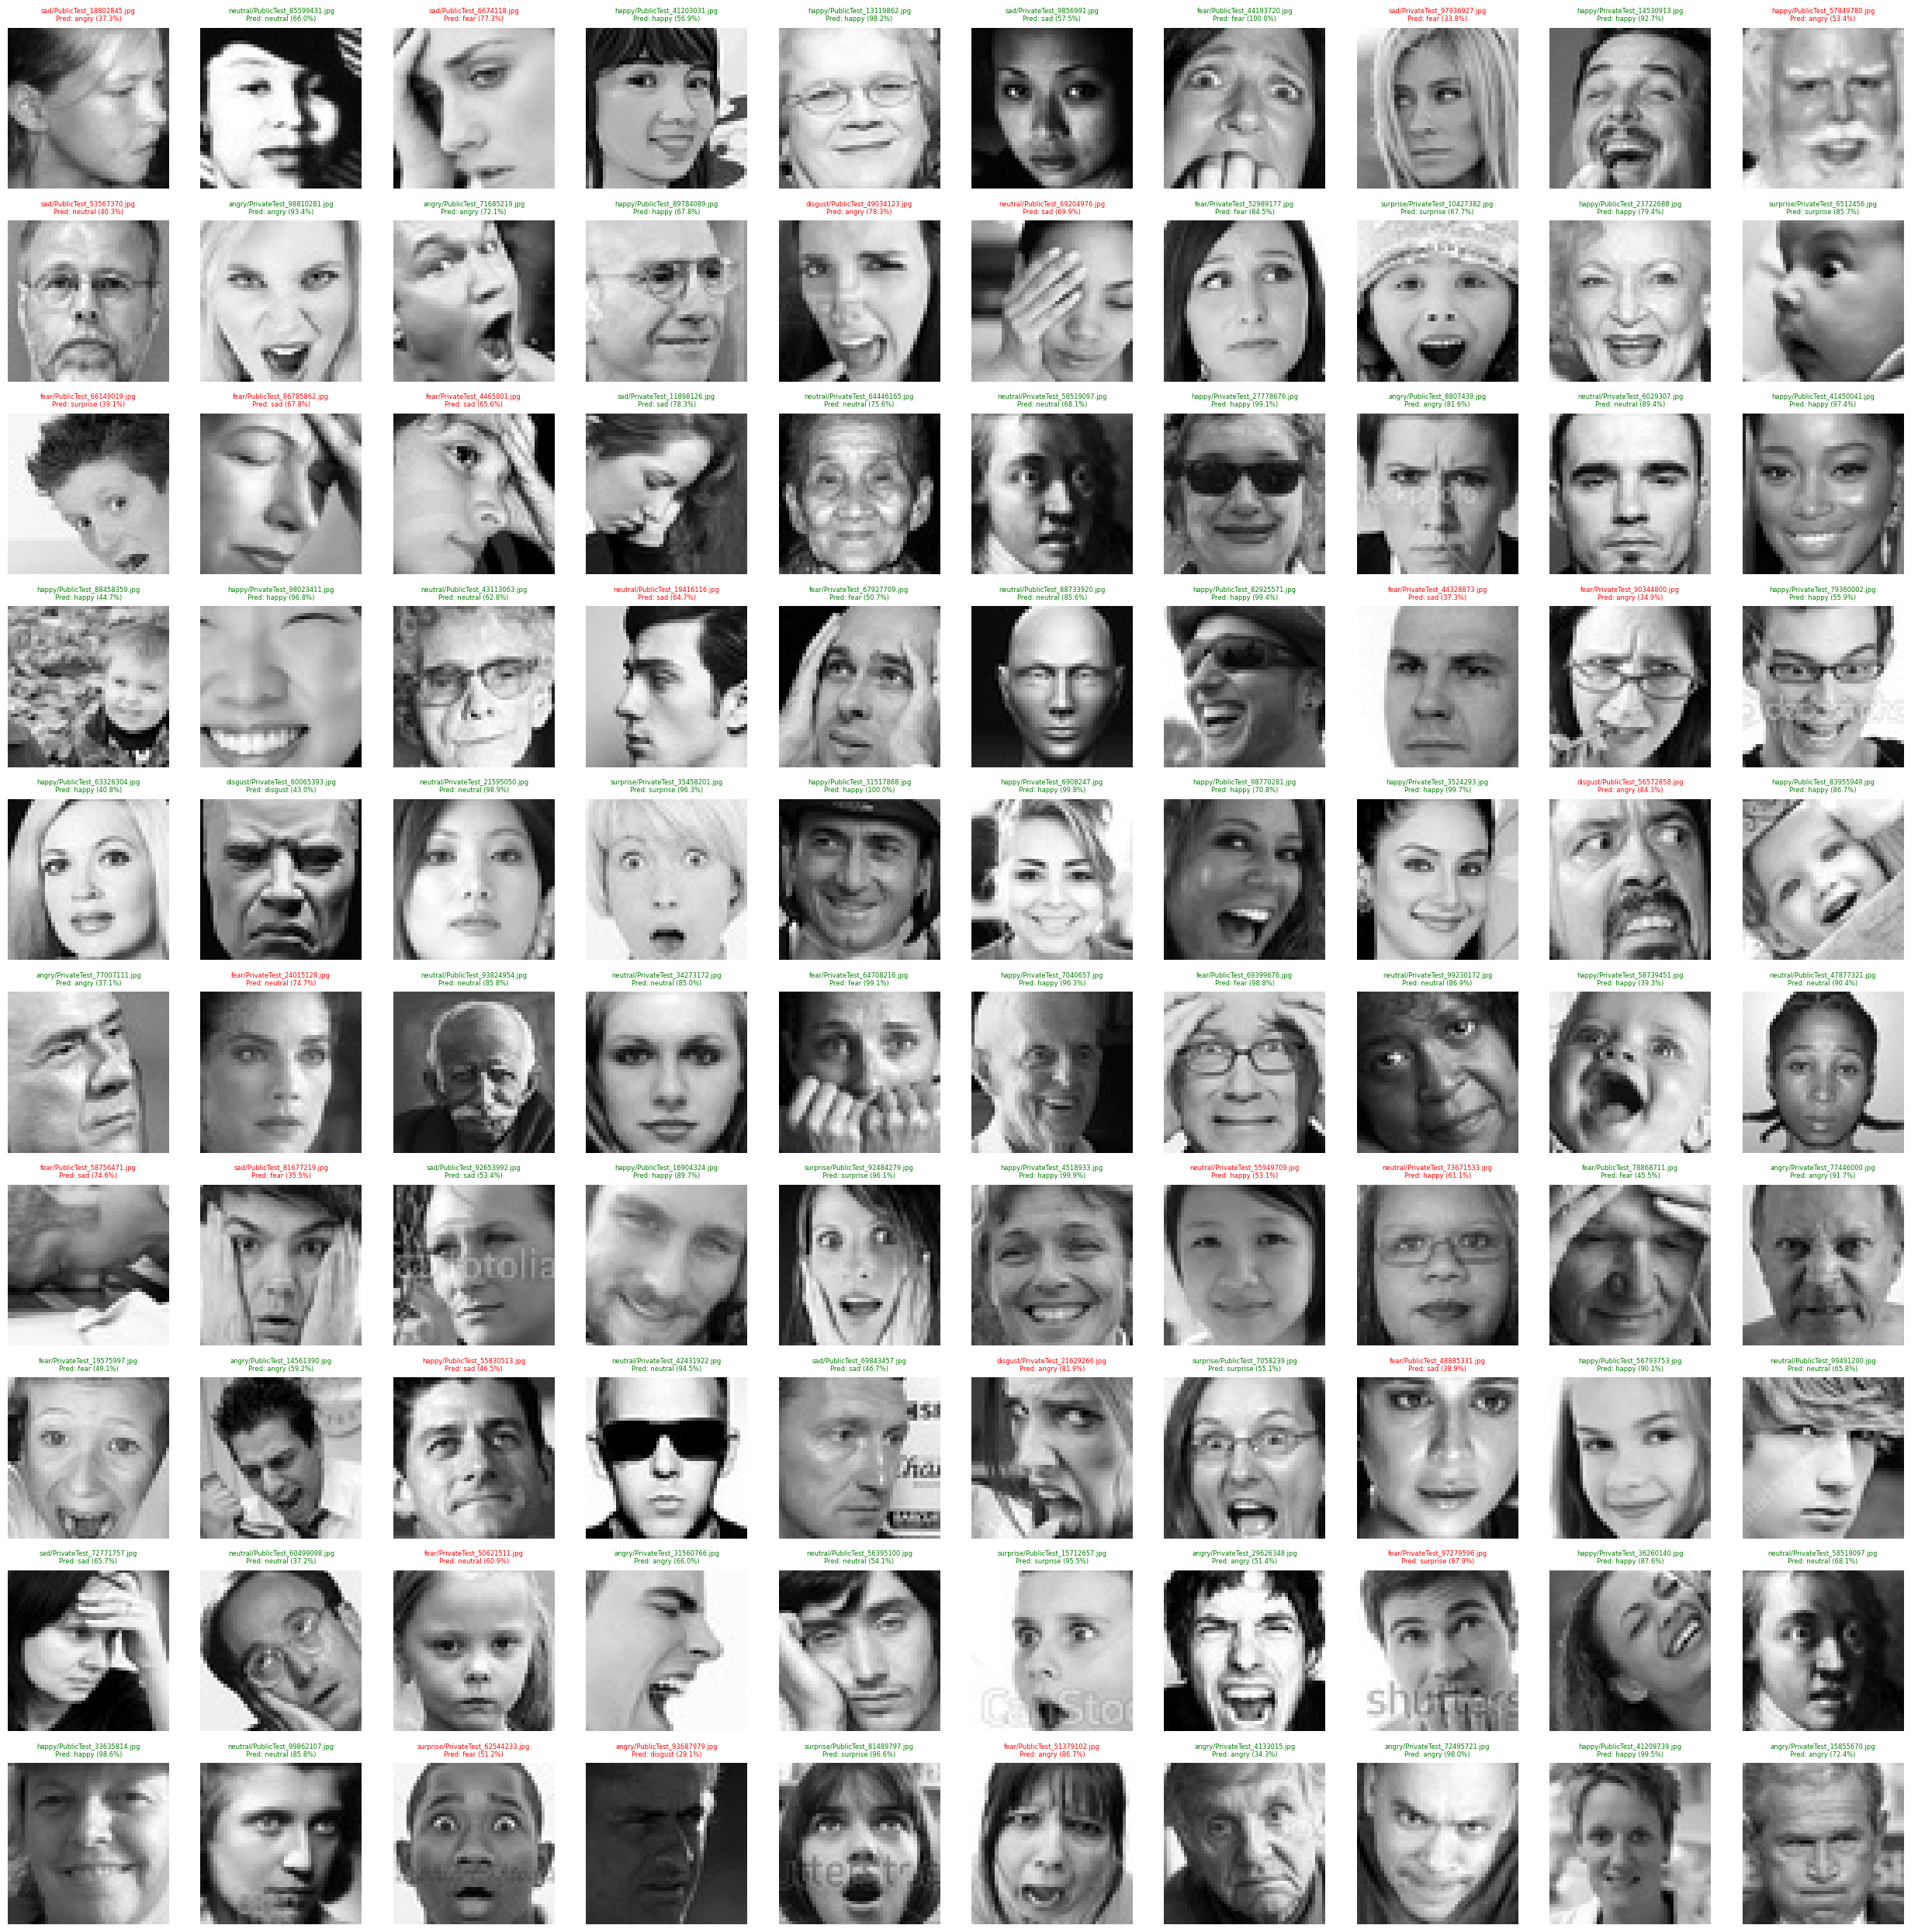

Correctly Predicted: 73 / 100


In [20]:
import matplotlib.pyplot as plt
import numpy as np
import os

filenames = test_generator.filepaths
plt.figure(figsize=(25, 25))

correct_count = 0

for i in range(100):
    index = np.random.randint(0, len(filenames))
    img_path = filenames[index]
    img = plt.imread(img_path)

    class_name = os.path.basename(os.path.dirname(img_path))
    filename = os.path.basename(img_path)

    true_label = class_labels[true_classes[index]]
    pred_label = class_labels[pred_classes[index]]
    confidence = np.max(pred_probs[index]) * 100

    if pred_label == true_label:
        correct_count += 1

    plt.subplot(10, 10, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    title_color = 'green' if pred_label == true_label else 'red'
    plt.title(f'{class_name}/{filename}\nPred: {pred_label} ({confidence:.1f}%)',
              fontsize=6, color=title_color)

plt.tight_layout()
plt.show()
print(f'Correctly Predicted: {correct_count} / 100')
